# DESC Lamp demo 
## Catalog extraction
This notebook shows how to pull postage stamps to use for strong gravitaional lens searches.

# DC2: Generate Postage Stamps (Cutouts) for objects in the Object Catalog

Owner: **Rémy Joseph** ([@herjy](https://github.com/herjy/DESC-Lamp))
<br>Last Verified to Run: **2021-11-22** (by @herjy)

This notebook is partly based on the `dm_butler_postage_stamps_for_object_catalogs` notebook by Yao-Yuan Mao and the previous notebooks `dm_butler_postage_stamps` notebook by Michael Wood-Vasey and the Stack Club `ButlerTutorial` by Daniel Perrefort.

Light curve extraction follows the `dia_sn_vs_truth` notebook by Michael Wood-Vasey.

Here we simply copy what was in Yao-Yuan's notebook and trim it to the usecase of selecting galaxies from cosmoDC2 catalogs with magnitude cuts. The notebook will in fine evolve to incorporate the functions we design to streamline this preselection process.

### Logistics
This is intended to be runnable at NERSC through the https://jupyter.nersc.gov interface from a local git clone of https://github.com/herjy/DESC-Lamp in your NERSC directory.  But you can also run it wherever, with appropriate adjustment of the 'repo' location to point to a place where you have a Butler repo will all of the images. 

This notebook uses the `desc-stack-weekly-latest` kernel. Instructions for setting up the proper DESC python kernel can be found here: https://confluence.slac.stanford.edu/x/o5DVE

## Set up

First we will load the needed modules and DC2 DR6 data sets: object catalogs (with `GCRCatalogs`) and DRP products (with `desc_dc2_dm_data`).

In [1]:
from desclamp import postage
import lenstronomy 
import galsim
# A few common packages
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pickle
%matplotlib inline

# We will use astropy's WCS and ZScaleInterval for plotting
from astropy.wcs import WCS
from astropy.visualization import ZScaleInterval
# Also to convert sky coordinates
from astropy.coordinates import SkyCoord
import astropy.units as u

# We will use several stack functions
import lsst.geom
import lsst.afw.display as afwDisplay
import lsst.afw.display.rgb as rgb

# And also DESC packages to get the data path
import GCRCatalogs
from GCRCatalogs import GCRQuery
import desc_dc2_dm_data

We will be using the DC2 Run 2.2i DR6 v2 data. The catalogs and there validation are described here: https://arxiv.org/pdf/2110.03769.pdf


In [2]:
dc2_data_version = "2.2i_dr6"
GCRCatalogs.get_available_catalogs(names_only=True, name_contains=dc2_data_version)
cat = GCRCatalogs.load_catalog("dc2_object_run"+dc2_data_version)
diaSrc = GCRCatalogs.load_catalog('dc2_dia_source_run1.2p_test')
diaObject = GCRCatalogs.load_catalog('dc2_dia_object_run1.2p_test')
truth_lc = GCRCatalogs.load_catalog('dc2_truth_run2.2i_sn_truth_summary')


In [3]:
lampion = postage.Candidates("2.2i_dr6")

/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-0.5.0/lib/python3.8/site-packages/desc_dc2_dm_data/butler.py:29: FutureWarning: Gen2 Butler has been deprecated (Butler). It will be removed sometime after v23.0 but no earlier than the end of 2021.
  return Butler(REPOS[run])
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-0.5.0/lib/python3.8/site-packages/desc_dc2_dm_data/butler.py:29: FutureWarning: Gen2 Butler has been deprecated (ImsimMapper). It will be removed sometime after v23.0 but no earlier than the end of 2021.
  return Butler(REPOS[run])


All the catalog names (including old catalogs) can be found by uncommenting the line below.
Information obout these catalogs can be found in the [DC2 data product overview](https://confluence.slac.stanford.edu/display/LSSTDESC/DC2+Data+Product+Overview). The Rubin project's [Data product definition document](https://docushare.lsstcorp.org/docushare/dsweb/Get/LSE-163/LSE-163_DataProductsDefinitionDocumentDPDD.pdf)(DPDD) provides further insight into the content of these catalogs. 

These are [GCR catalogs](https://github.com/LSSTDESC/gcr-catalogs) that may use slightly different definitions and namings than the one used in Rubin's DPDD. The details for the entries of these catalogs can be found in the [GCR Catalogs SChema description](https://github.com/LSSTDESC/gcr-catalogs/blob/master/GCRCatalogs/SCHEMA.md#schema-for-dc2-object-catalogs)

In [4]:
print('\n'.join(sorted(GCRCatalogs.get_available_catalogs(include_default_only=False))))

base5000_v1.1.1
base5000_v1.1.1_9431_9812
base5000_v1.1.1_9556
base5000_v1.1.1_image
base5000_v1.1.1_small
base5000_v1.1.1_z_0_1
base5000_v1.1.1_z_1_2
baseDC2_snapshot_z0.15_v0.1
baseDC2_snapshot_z0.15_v0.1_small
baseDC2_snapshot_z1.01_v0.1
baseDC2_v1.1_9431_9812
baseDC2_v1.1_9556
baseDC2_v1.1_image
buzzard
buzzard_high-res
buzzard_high-res_v1.1
buzzard_test
buzzard_v2.0.0_3
buzzard_v2.0.0_4
buzzard_v2.0.0_test
cosmoDC2
cosmoDC2_v1.0
cosmoDC2_v1.0_10194_10452
cosmoDC2_v1.0_8786_9049
cosmoDC2_v1.0_9050_9430
cosmoDC2_v1.0_9431_9812
cosmoDC2_v1.0_9556
cosmoDC2_v1.0_9813_10193
cosmoDC2_v1.0_image
cosmoDC2_v1.0_image_addon_knots
cosmoDC2_v1.0_small
cosmoDC2_v1.1.4
cosmoDC2_v1.1.4_image
cosmoDC2_v1.1.4_image_addon_knots
cosmoDC2_v1.1.4_image_combined_agn
cosmoDC2_v1.1.4_image_with_photoz_calib
cosmoDC2_v1.1.4_image_with_photozs_flexzboost_v1
cosmoDC2_v1.1.4_image_with_photozs_v1
cosmoDC2_v1.1.4_parquet
cosmoDC2_v1.1.4_redmapper_v0.7.5
cosmoDC2_v1.1.4_small
cosmoDC2_v1.1.4_small_combined_agn


## Select a sample of galaxies based on selection criteria

Here we will use arbitrary (actually from [Rojas et al. 2021](https://arxiv.org/pdf/2109.00014.pdf)) selection criteria to extract a few moock patches.

To learn what columns are in the object catalogs, refer to [this schema table](https://github.com/LSSTDESC/gcr-catalogs/blob/master/GCRCatalogs/SCHEMA.md#schema-for-dc2-object-catalogs). And sometimes it'd be helpful to look at the [source code](https://github.com/LSSTDESC/gcr-catalogs/blob/master/GCRCatalogs/dc2_object.py#L341).

In [5]:
bright_galaxy_query = GCRQuery(
    "clean",
    "extendedness == 1",
    "mag_g_cModel- mag_i_cModel < 5",
    "mag_g_cModel- mag_i_cModel > 1.8",
    "mag_g_cModel- mag_r_cModel < 3",
    "mag_g_cModel- mag_r_cModel > 0.6",
    "mag_r_cModel < 22.5",
    "mag_r_cModel > 18",
    "mag_g_cModel > 20",
    "mag_i_cModel > 18.2",
    "snr_g_cModel > 10",
    "snr_r_cModel > 10",
    "snr_i_cModel > 10",
)
objects = lampion.catalog_query(bright_galaxy_query, tracts=[4639])
print(f"The query returned {len(objects['tract'])} results. Let's not display them all")

/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-0.5.0/lib/python3.8/site-packages/GCRCatalogs/dc2_dm_catalog.py:43: RuntimeWarning: divide by zero encountered in log10
  return -2.5 * np.log10(flux) + AB_mag_zp_wrt_nanoJansky
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-0.5.0/lib/python3.8/site-packages/GCRCatalogs/dc2_dm_catalog.py:43: RuntimeWarning: invalid value encountered in log10
  return -2.5 * np.log10(flux) + AB_mag_zp_wrt_nanoJansky


The query returned 9617 results. Let's not display them all


## Extracting postage stamps

Now we need to extract postage stamps of the coadded images. For that we need for each object there coordinates, but also there tact and patch number.

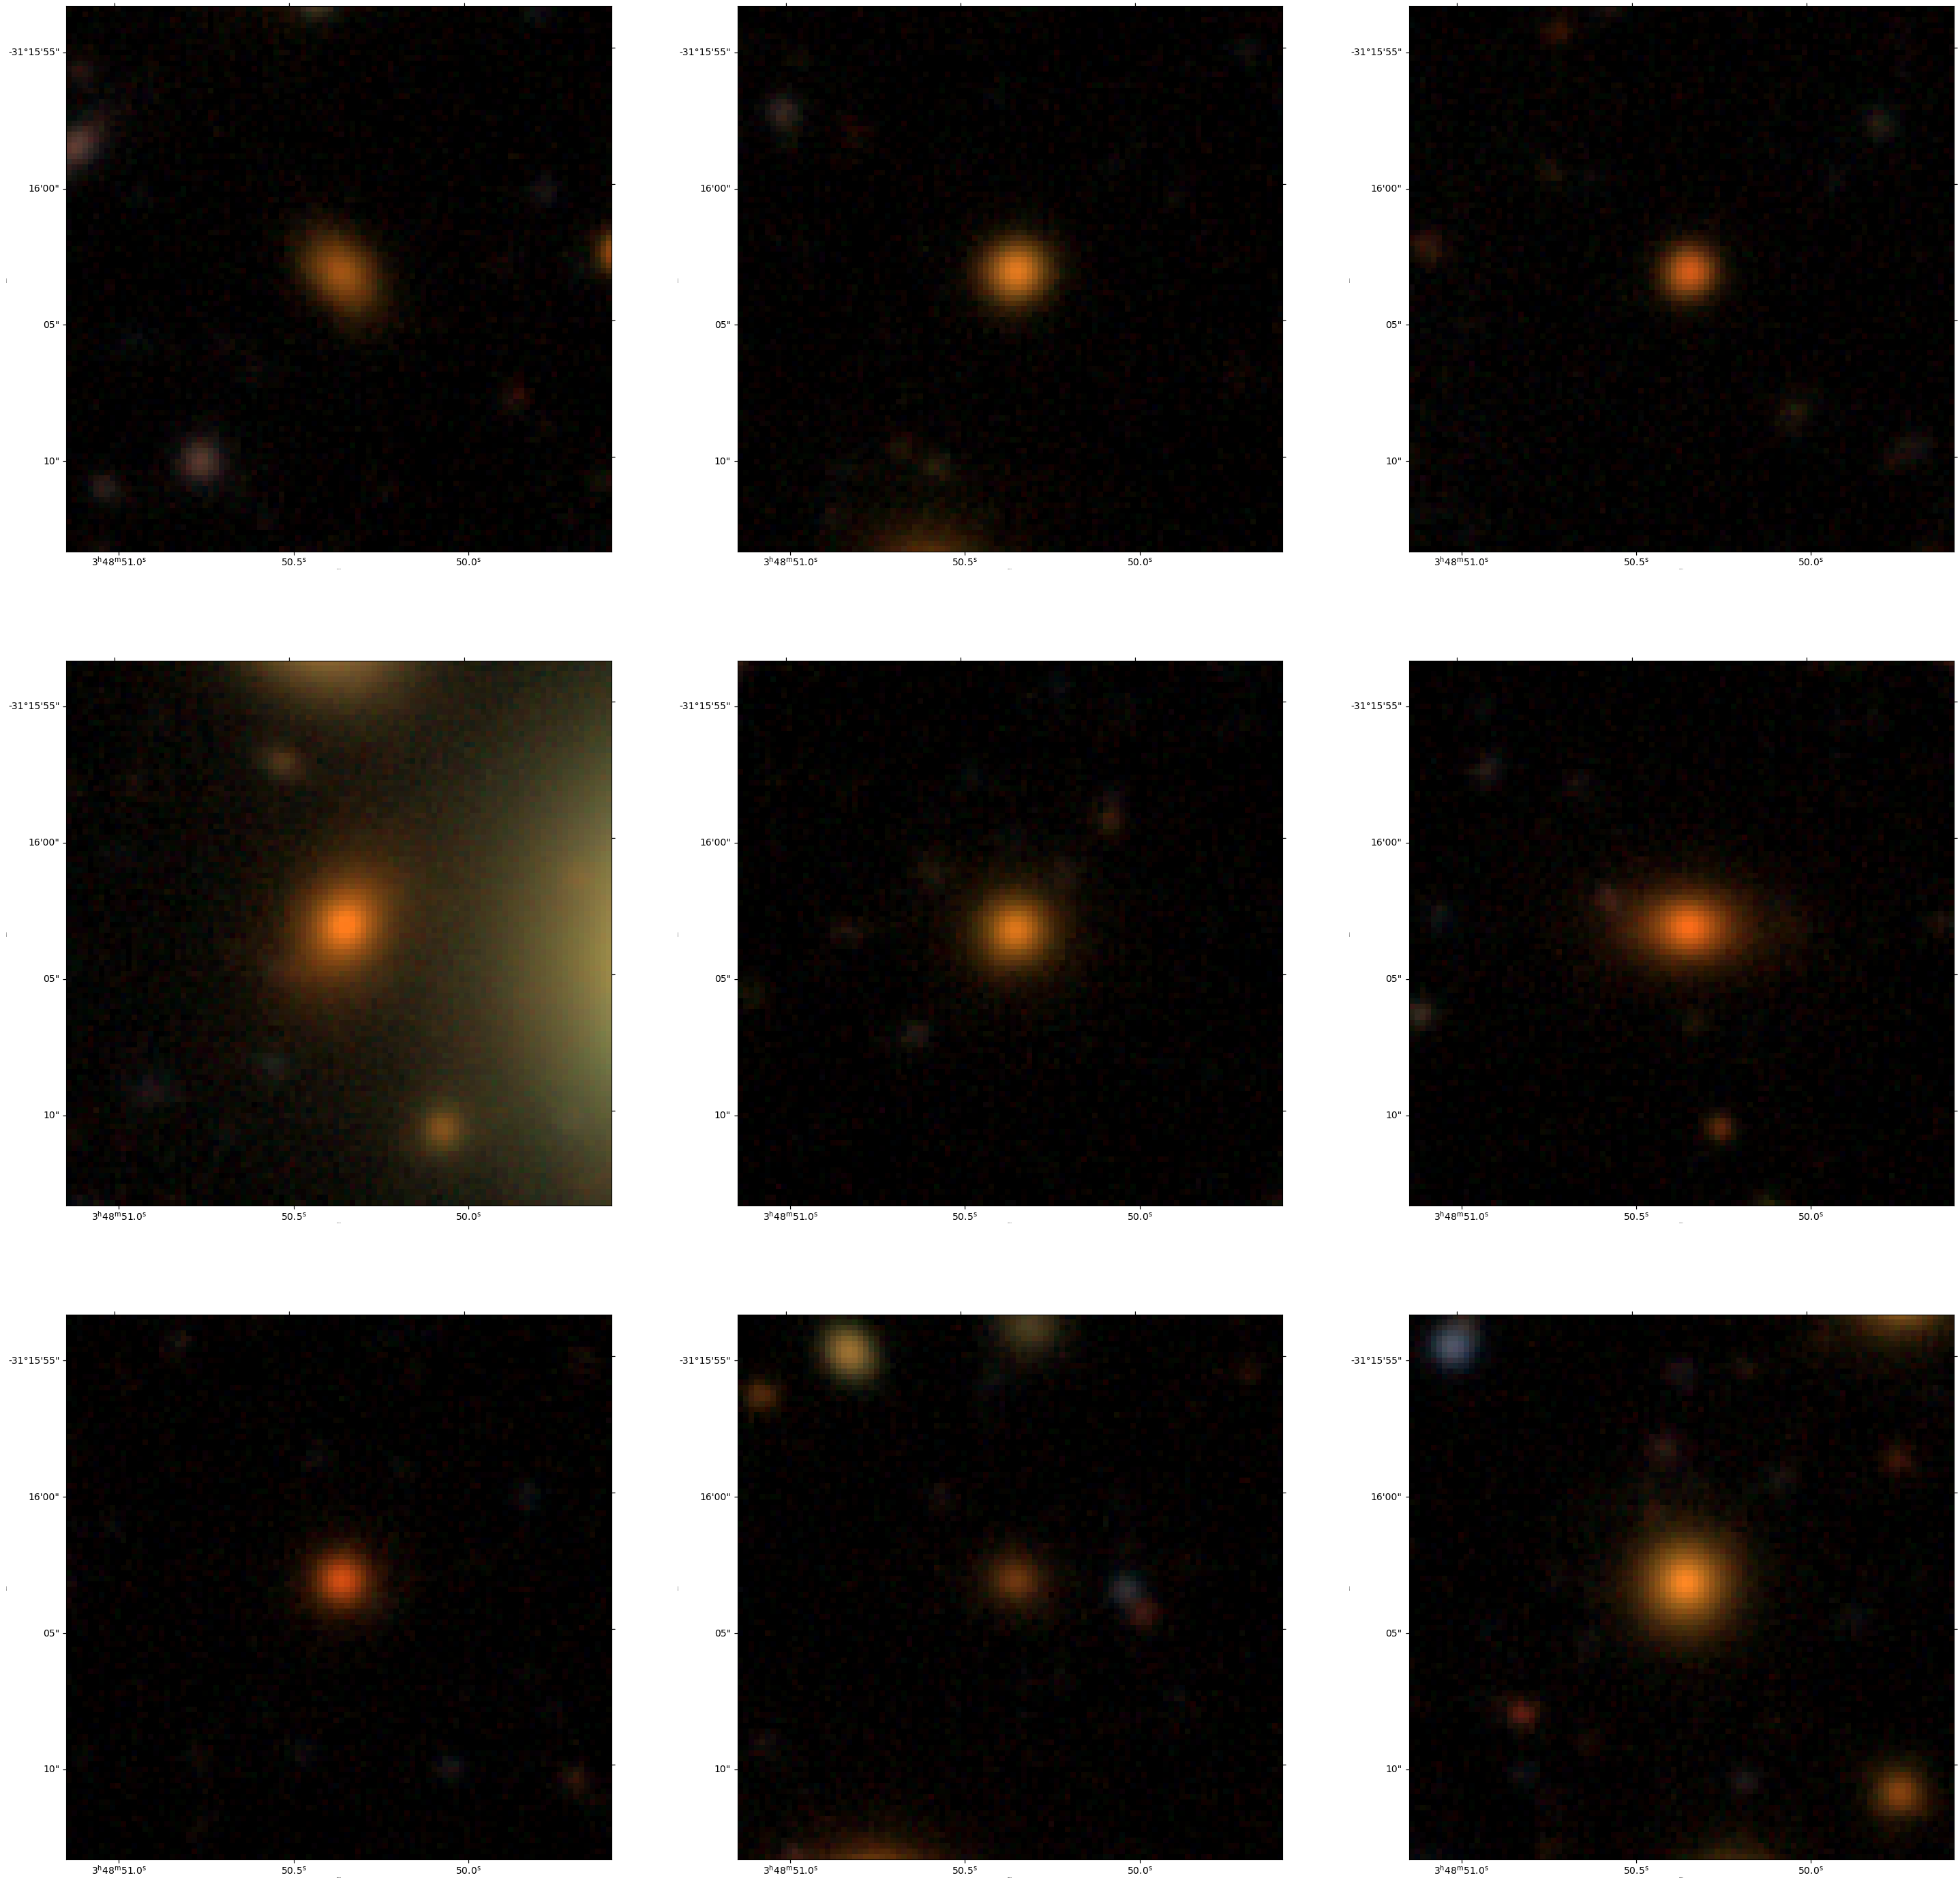

In [6]:
cutouts = lampion.make_postage_stamps(objects.loc[:8], cutout_size=100, bands = 'irg')
lampion.display_cutouts(cutouts, cutout_size=45)

Now we build a function that will get tratc and patch inforrmation for a given (Ra, Dec) position:

In [7]:
fig = plt.figure(figsize=(36, 36), dpi=100)
gs = plt.GridSpec(6, 6, fig)

from lsst.pipe.tasks.insertFakes import _add_fake_sources

#Limiting to 16 objects
n0 = 72
objects_sel = objects.loc[:25]

file = open('lensed_source','rb')
lensed_source = pickle.load(file, encoding='bytes')


gsobj_r = galsim.InterpolatedImage(galsim.Image(lensed_source), scale = 0.05, flux = 800)
gsobj_g = galsim.InterpolatedImage(galsim.Image(lensed_source), scale = 0.05, flux = 1000)
gsobj_b = galsim.InterpolatedImage(galsim.Image(lensed_source), scale = 0.05, flux = 1500)

cutout_size = 45
cutout_extent = lsst.geom.ExtentI(cutout_size, cutout_size)
id=0
for (_, object_this), gs_this in zip(objects_sel.iterrows(), gs):
    radec = lsst.geom.SpherePoint(object_this["ra"], object_this["dec"], lsst.geom.degrees)
    center = skymap.findTract(radec).getWcs().skyToPixel(radec)
    bbox = lsst.geom.BoxI(lsst.geom.Point2I((center.x - cutout_size*0.5, center.y - cutout_size*0.5)), cutout_extent)

    cutouts = [butler.get("deepCoadd_sub", bbox=bbox, tract=object_this["tract"], patch=object_this["patch"], filter=band) for band in "irg"]
    wcs_fits_meta = cutouts[0].getWcs().getFitsMetadata()
    
    image_rgb = rgb.makeRGB(*cutouts, dataRange = 2, Q=8)
    #del cutouts  # let gc save some memory for us

    ax = plt.subplot(gs[id], projection=WCS(wcs_fits_meta), label=str(object_this["objectId"]))
    ax.imshow(image_rgb, origin='lower')
    del image_rgb  # let gc save some memory for us
    
    for c in ax.coords:
        c.set_ticklabel(exclude_overlapping=True, size=10)
        c.set_axislabel('', size=0)
    id+=1


NameError: name 'skymap' is not defined

<Figure size 3600x3600 with 0 Axes>

## Insert lensed sources

In [ ]:
fig = plt.figure(figsize=(36, 36), dpi=100)
gs = plt.GridSpec(6, 6, fig)

file = open('lensed_source','rb')
lensed_source = pickle.load(file, encoding='bytes')
objects_sel = objects.loc[:100]

gsobj_r = galsim.InterpolatedImage(galsim.Image(lensed_source), scale = 0.05, flux = 800)
gsobj_g = galsim.InterpolatedImage(galsim.Image(lensed_source), scale = 0.05, flux = 1000)
gsobj_b = galsim.InterpolatedImage(galsim.Image(lensed_source), scale = 0.05, flux = 1500)

cutout_extent = lsst.geom.ExtentI(cutout_size, cutout_size)
cutout_list = []
id=0
for (_, object_this), gs_this in zip(objects_sel.iterrows(), gs):
    radec = lsst.geom.SpherePoint(object_this["ra"], object_this["dec"], lsst.geom.degrees)
    center = skymap.findTract(radec).getWcs().skyToPixel(radec)
    bbox = lsst.geom.BoxI(lsst.geom.Point2I((center.x - cutout_size*0.5, center.y - cutout_size*0.5)), cutout_extent)

    cutouts = [butler.get("deepCoadd_sub", bbox=bbox, tract=object_this["tract"], patch=object_this["patch"], filter=band) for band in "irg"]
    wcs_fits_meta = cutouts[0].getWcs().getFitsMetadata()
    
    image_rgb = rgb.makeRGB(*cutouts, dataRange = 2, Q=8)
    #del cutouts  # let gc save some memory for us
    while id<36:
        cutout_list.append(image_rgb[:,:,0])
        ax = plt.subplot(gs[id], projection=WCS(wcs_fits_meta), label=str(object_this["objectId"]))
        ax.imshow(image_rgb, origin='lower')
        
    
    # Synthetic lensed source injection
        _add_fake_sources(cutouts[0], [(radec, gsobj_r)])
        _add_fake_sources(cutouts[1], [(radec, gsobj_g)])
        _add_fake_sources(cutouts[2], [(radec, gsobj_b)])
    
        lens_rgb = rgb.makeRGB(*cutouts, dataRange = 2, Q=8)
        #del cutouts  # let gc save some memory for us
        cutout_list.append(lens_rgb[:,:,0])
        ax = plt.subplot(gs[id+1], projection=WCS(wcs_fits_meta), label=str(object_this["objectId"]+1))
        ax.imshow(lens_rgb, origin='lower')
        
    
        for c in ax.coords:
            c.set_ticklabel(exclude_overlapping=True, size=10)
            c.set_axislabel('', size=0)
    del lens_rgb  # let gc save some memory for us
    del image_rgb  # let gc save some memory for us
    id+=2
cutout_list = np.array(cutout_list)

## Run classifier on postage stamps

In [ ]:
#model = np.load("/global/homes/r/remyj/git_repos/ml_classification_studies/cosmoDNN/Classification/trained_models/LensJPG_stack_opti0_loss0_lr0.0005_decay0.0_batch8_epoch450.npy") 
from tensorflow import keras
path = "/global/homes/r/remyj/git_repos/ml_classification_studies/cosmoDNN/Classification/trained_models/"
model = keras.models.load_model(path+"LensJPG_stack_opti0_loss0_lr0.0005_decay0.0_batch8_epoch450.hdf5")
weights = np.load(path+"LensJPG_stack_opti0_loss0_lr0.0005_decay0.0_batch8_epoch450.npy")
model.fit(cutout_list, truth)
cutout_list = np.array(cutout_list)
keras.utils.plot_model(model, show_shapes=True)
print(cutout_list.shape)

In [ ]:
pred = model.predict(cutout_list)
print(len(cutout_list))
truth = np.ones((len(cutout_list),2))
truth[::2,0] = 0
truth[::2,1] = 0
plt.plot(np.mean(pred, axis = 1))
plt.show()
plt.plot(truth*np.max(pred[:,1]))
plt.show()

## Extracting light curves

To search for lensed transients, it is useful to have access to light curves. These are extracted from Difference Imaging Analysis (DIA). We used the scripts provided in the `dia_sn_vs_truth` notebook by Michael Wood-Vasey to produce the following light curves.

First, we need to match the position of objects to sources in the DIA catalogs:

In [ ]:
# Match on RA, Dec

for i in range(len(objects_sel)):
    sn_position = SkyCoord(objects.loc[i]["ra"], objects.loc[i]["dec"], unit='deg')

    diaObjects_cat = diaObject.get_quantities(['ra', 'dec', 'diaObjectId'])
    diaObject_positions = SkyCoord(diaObjects_cat['ra'], diaObjects_cat['dec'], unit='deg')

    idx, sep2d, _ = sn_position.match_to_catalog_sky(diaObject_positions)
    
    print(f'Index: {idx} is {sep2d.to(u.arcsec)[0]:0.6f} away')

In [ ]:
diaObjects_cat = pd.DataFrame(diaObjects_cat)
objects_sel = diaObjects_cat.loc[:36]

cutout_size = 100
cutout_extent = lsst.geom.ExtentI(cutout_size, cutout_size)
id=0
for (_, object_this), gs_this in zip(objects_sel.iterrows(), gs):
    radec = lsst.geom.SpherePoint(object_this["ra"], object_this["dec"], lsst.geom.degrees)
    center = skymap.findTract(radec).getWcs().skyToPixel(radec)
    bbox = lsst.geom.BoxI(lsst.geom.Point2I((center.x - cutout_size*0.5, center.y - cutout_size*0.5)), cutout_extent)

    cutouts = [butler.get("deepCoadd_sub", bbox=bbox, tract=4839, patch="0,0", filter=band) for band in "irg"]
    wcs_fits_meta = cutouts[0].getWcs().getFitsMetadata()
    image_rgb = rgb.makeRGB(*cutouts)
    del cutouts  # let gc save some memory for us

    ax = plt.subplot(gs_this, projection=WCS(wcs_fits_meta), label=str(object_this["objectId"]))
    ax.imshow(image_rgb, origin='lower')
    del image_rgb  # let gc save some memory for us
    
    for c in ax.coords:
        c.set_ticklabel(exclude_overlapping=True, size=10)
        c.set_axislabel('', size=0)


In [ ]:
def plot_lightcurve(df, plot='mag', flux_col_names=None,
                    title=None, marker='o', linestyle='none',
                    colors=None, label_prefix='',
                    **kwargs):
    """Plot a lightcurve from a DataFrame.
    """
    # At lexigraphical order, if not wavelength order.
    # Assume fixed list of filters.
    filter_order = ['u', 'g', 'r', 'i', 'z', 'y']

    if colors is None:
        colors = {'u': 'violet', 'g': 'indigo', 'r': 'blue', 'i': 'green', 'z': 'orange', 'y': 'red'}
    
    if flux_col_names is not None:
        flux_col, flux_err_col = flux_col_names
    else:
        if plot == 'flux':
            flux_col = 'psFlux'
            flux_err_col = 'psFluxErr'
        else:
            flux_col = 'mag'
            flux_err_col = 'mag_err'
        
    for filt in filter_order:
        this_filter = df.query(f'filter == "{filt}"')
        if this_filter.empty:
            continue
        # This if sequence is a little silly.
        plot_kwargs = {'linestyle': linestyle, 'marker': marker, 'color': colors[filt],
                       'label': f'{label_prefix} {filt}'}
        plot_kwargs.update(kwargs)

        if flux_err_col in this_filter.columns:
            plt.errorbar(this_filter['mjd'], this_filter[flux_col], this_filter[flux_err_col],
                         **plot_kwargs)
                        
        else:
            if marker is None:
                plt.plot(this_filter['mjd'], this_filter[flux_col], **plot_kwargs)

            else:
                plot_kwargs.pop('linestyle')
                plt.scatter(this_filter['mjd'], this_filter[flux_col], **plot_kwargs)



    plt.xlabel('MJD')

    if plot == 'flux':
        plt.ylabel('psFlux [nJy]')
    else:
        # Ensure that y-axis decreases as one goes up
        # Because plot_lightcurve could be called several times on the same axis,
        # simply inverting is not correct.  We have to reverse a sorted list.
        plt.ylim(sorted(plt.ylim(), reverse=True))
        plt.ylabel('mag [AB]')

    if title is not None:
        plt.title(title)
    plt.legend()